In [ ]:
from google.colab import files
from google.colab import drive

files.upload()
#upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"benjaminbutch","key":"db2f86f61ac7a18276861c2a7721213b"}'}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g5iRVib4m5u4DLXEwKcfgp1G9zCEREhXWp7c1smlFwv9H3AJdO1gdI


ValueError: ignored

In [ ]:
!pip install -q kaggle


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
#downloads the dataset as a zip

In [ ]:
!rm -fr /content/chest_xray/

In [ ]:
!unzip -q chest-xray-pneumonia.zip -x "/chest_xray/chest_xray"
#unzips the dataset so we can use it

caution: excluded filename not matched:  /chest_xray/chest_xray


In [ ]:
!mkdir /content/chest_xray/train/Mixed
!mkdir /content/chest_xray/test/Mixed
!mkdir /content/chest_xray/States
!mkdir /content/chest_xray/val/Mixed
!cp -fr /content/chest_xray/train/NORMAL/ /content/chest_xray/train/Mixed && cp -fr /content/chest_xray/train/PNEUMONIA/ /content/chest_xray/train/Mixed
!cp -fr /content/chest_xray/test/NORMAL/ /content/chest_xray/val/Mixed && cp -fr /content/chest_xray/test/PNEUMONIA/ /content/chest_xray/val/Mixed
!cp -fr /content/chest_xray/val/NORMAL/ /content/chest_xray/test/Mixed && cp -fr /content/chest_xray/val/PNEUMONIA/ /content/chest_xray/test/Mixed
!rm -fr /content/chest_xray/test/NORMAL /content/chest_xray/test/PNEUMONIA
!rm -fr /content/chest_xray/train/NORMAL /content/chest_xray/train/PNEUMONIA /content/chest_xray/chest_xray/
!rm -fr /content/chest_xray/val/NORMAL /content/chest_xray/val/PNEUMONIA
!rm -fr /content/chest_xray/__MACOSX
#creates new directories and deletes copies of other directories so we can use them later as test, validation and training sets
#i swapped the validation and training set as the validation set only had 30 images which isnt ideal

In [ ]:
import numpy as np
import pandas as pd
import os
import warnings
from fastai.vision import *
from fastai.metrics import error_rate,accuracy
#imports numpy, pandas and fastai

In [ ]:
Path('/content/chest_xray/train/Mixed').ls()
#check that the required folders are in the Mixed directory

[PosixPath('/content/chest_xray/train/Mixed/NORMAL'),
 PosixPath('/content/chest_xray/train/Mixed/PNEUMONIA')]

In [ ]:
path_data = Path('/content/chest_xray')
path_data.ls()
#check to see if we have the train,test and validation folders set up

[PosixPath('/content/chest_xray/test'),
 PosixPath('/content/chest_xray/train'),
 PosixPath('/content/chest_xray/States'),
 PosixPath('/content/chest_xray/val')]

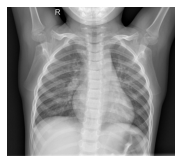

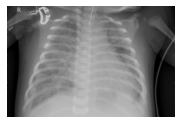

In [ ]:
imgnorm = open_image(path_data/'train'/'Mixed'/'NORMAL'/'IM-0115-0001.jpeg')
imgpneu = open_image(path_data/'train'/'Mixed'/'PNEUMONIA'/'person1000_bacteria_2931.jpeg')
imgnorm.show()
imgpneu.show()
#opens 2 images one from NORMAL and one from PNEUMONIA to double check we have successfully transfered the images 

In [ ]:
size = 512 #size of the image
bs = 16 #batch size
#went for a lower batch size as google colab ran out of memory at a higher batch size
np.random.seed(42)
ds_tfms = get_transforms(do_flip=False, flip_vert=False, max_rotate= 30,max_zoom=1.2, max_lighting=0.2, max_warp=0.3)
#with ds_tfms we decide not to flip the image and not to flip it vertically but decide to rotate it at a maximum 10 degrees
#and zoom in a maximum of 1.1 and to slightly warp the image so we can get better results

In [ ]:
warnings.filterwarnings('ignore')
#this is so we can ignore anywarnings that arent too important

In [ ]:
labels = os.listdir(path_data/'train/Mixed')
print("No. of labels: {}".format(len(labels)))
print("-----------------")


for label in labels:
  print("{}, {} files".format(label,len(os.listdir(str(Path('/content/chest_xray/train/Mixed'))+'/'+label))))
  #shows the number of images of each type in the training folder we will most likely only use 500 of these as it will take too long to use all of them

No. of labels: 2
-----------------
NORMAL, 1341 files
PNEUMONIA, 3875 files


In [ ]:
dir_listNormal=os.listdir(path_data/'train'/'Mixed'/'NORMAL')
dir_listPneu=os.listdir(path_data/'train'/'Mixed'/'PNEUMONIA')
print(len(dir_listNormal))
print(len(dir_listPneu))
split_normal = round(len(dir_listNormal)*0.4)
split_pneu = round(len(dir_listPneu)*0.2)
print(split_normal)
print(split_pneu)
i=len(dir_listNormal)-1
j=len(dir_listPneu)-1
while j >= split_pneu:
  os.remove(str(Path(path_data/'train'/'Mixed'/'PNEUMONIA'/dir_listPneu[j])))
  #print("P" + str(j))
  j=j-1
while i >= split_normal:
  os.remove(str(Path(path_data/'train'/'Mixed'/'NORMAL'/dir_listNormal[i])))
  #print("N" + str(i))
  i=i-1

#this code deletes a good fraction of data in the training set because we had too much data in there in the first place
  

1341
3875
536
775


In [ ]:
labels = os.listdir(path_data/'train/Mixed')
print("No. of labels: {}".format(len(labels)))
print("-----------------")


for label in labels:
  print("{}, {} files".format(label,len(os.listdir(str(Path('/content/chest_xray/train/Mixed'))+'/'+label))))
  #shows us how many are left after the removal of data

No. of labels: 2
-----------------
NORMAL, 536 files
PNEUMONIA, 775 files


In [ ]:
data = (ImageList.from_folder(path_data)
.split_by_folder(train = 'train', valid = 'val')
.label_from_folder().transform(ds_tfms,size=size)
.databunch(bs = bs, num_workers = 4)
.normalize(imagenet_stats))



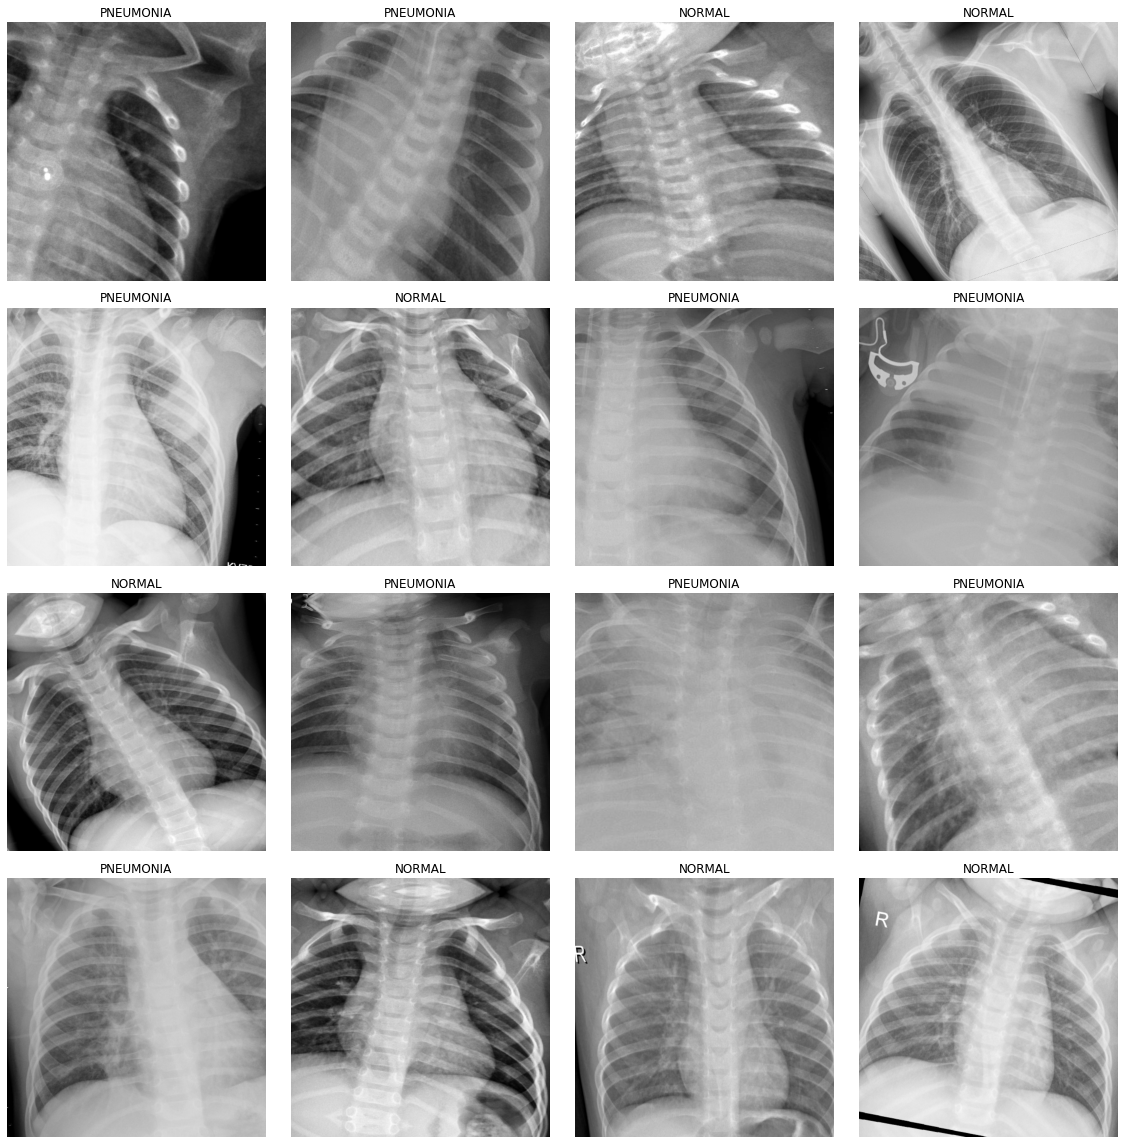

In [ ]:
data.show_batch()

#shows us part of the batch we have got for our data

we decide to use resnet101 due to us wanting to maximise accuracy over efficiency as resnet101 is easier to train and require fewer epochs to reach a better performance than Efficient nets.

and we decide to use resnet101 over resnet50 due to having a lower top-1 error rate and top-5 error rate than resnet50



Olga Miezwa-Sumila (October 20, 2020) ~ Getting Started With Image Classification: fastai, ResNet, MobileNet, and More from https://python-bloggers.com/2020/10/getting-started-with-image-classification-fastai-resnet-mobilenet-and-more/





In [ ]:
#learn =cnn_learner(data, models.resnet101, metrics=[accuracy,error_rate], callback_fns=ShowGraph ,model_dir="/tmp/model/")
#we start the ai with a set model using the data we have and adding accuracy and error rate in to show us how successful it is
#callback_fns=showgraph is to show us a graph after it is done

#learn =cnn_learner(data, models.resnet50, metrics=[accuracy,error_rate], callback_fns=ShowGraph ,model_dir="/tmp/model/")
#i tried resnet101 but it was too complex for the dataset and was overfitting it too quickly so ive gone down to resnet 50 as it seemed to of worked slightly better

learn =cnn_learner(data, models.resnet18, metrics=[accuracy,error_rate], callback_fns=ShowGraph ,model_dir="/tmp/model/")
#resnet50 worked well but i wondered if i could get the accuracy higher with a simpler model


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
learn.model
#this sets up the model we have chosen as our ai

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
#learn.fit_one_cycle(5)
#this uses the model to train the ai a set number of times so it will loop through the data five times here but we wont use it due to use wanting to save at each epoch to decide the best one to use

current cycle?30
Epoch 1


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.148111,0.299866,0.935897,0.064103,02:17


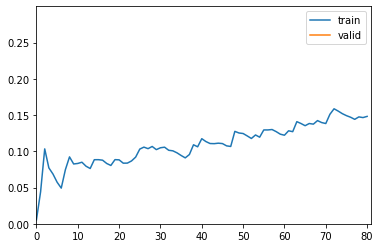

Epoch 2


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.138428,0.259322,0.934295,0.065705,02:18


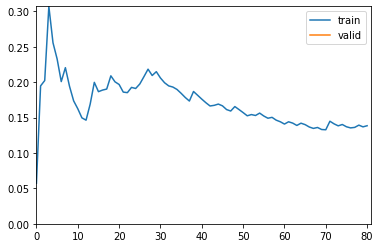

Epoch 3


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.114769,0.311284,0.932692,0.067308,02:17


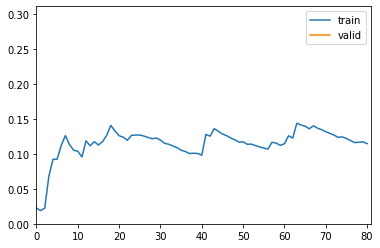

Epoch 4


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.135786,0.359662,0.911859,0.088141,02:17


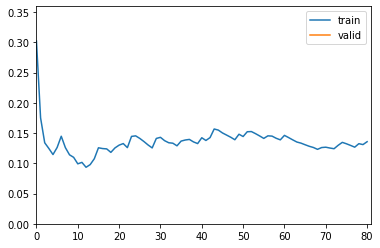

Epoch 5


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.116149,0.324713,0.921474,0.078526,02:18


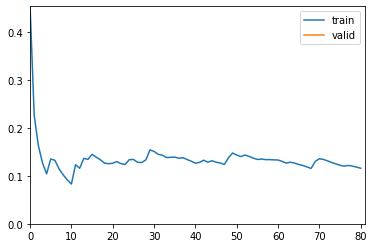

Epoch 6


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.111673,0.377839,0.907051,0.092949,02:18


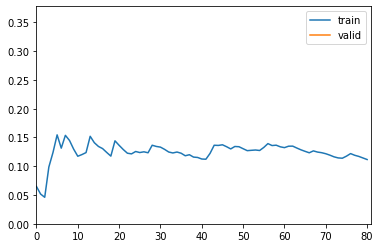

Epoch 7


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.117618,0.372504,0.916667,0.083333,02:17


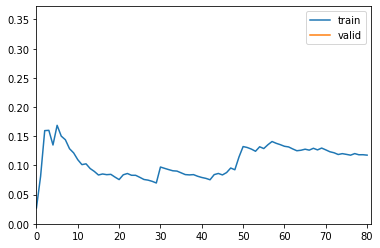

Epoch 8


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.115101,0.350807,0.932692,0.067308,02:15


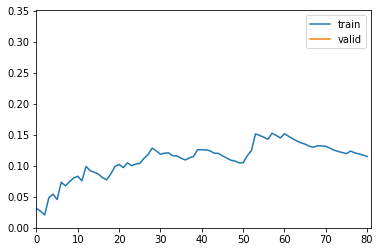

Epoch 9


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.139369,0.398684,0.918269,0.081731,02:18


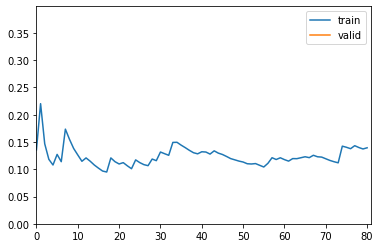

Epoch 10


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.093214,0.422129,0.927885,0.072115,02:18


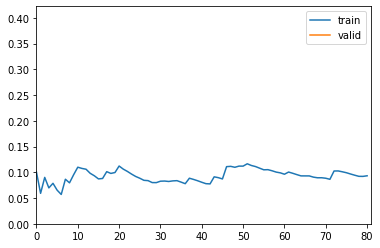

Epoch 11


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.121476,0.358015,0.931090,0.068910,02:19


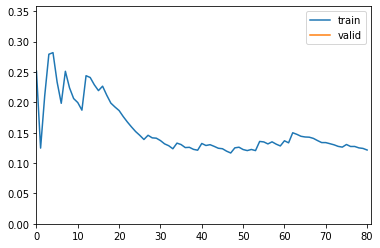

Epoch 12


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.145292,0.299657,0.937500,0.062500,02:20


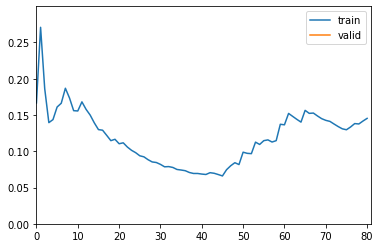

Epoch 13


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.114743,0.389388,0.923077,0.076923,02:21


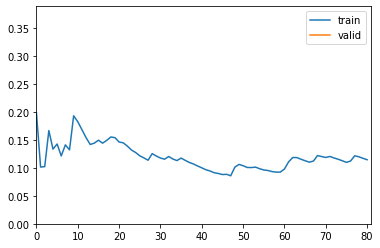

Epoch 14


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.138927,0.345128,0.929487,0.070513,02:21


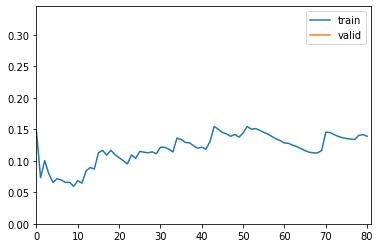

Epoch 15


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.081334,0.342338,0.923077,0.076923,02:21


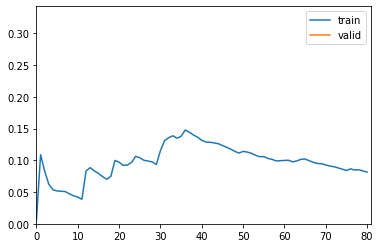

Epoch 16


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.113288,0.330319,0.934295,0.065705,02:19


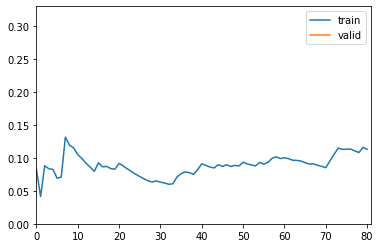

Epoch 17


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.128760,0.353512,0.927885,0.072115,02:20


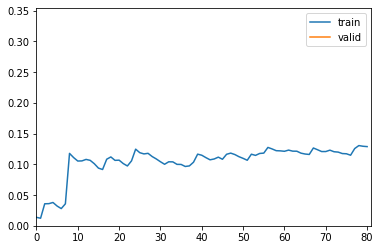

Epoch 18


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.159596,0.357879,0.927885,0.072115,02:19


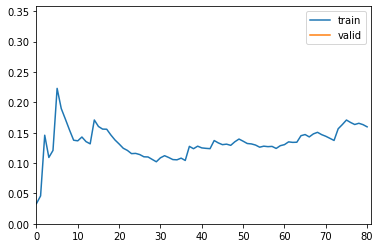

Epoch 19


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.099073,0.365005,0.929487,0.070513,02:19


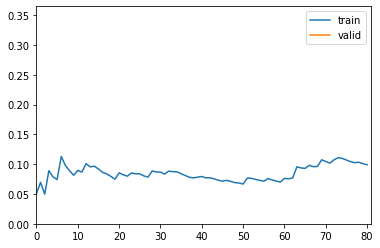

Epoch 20


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.089112,0.432098,0.926282,0.073718,02:21


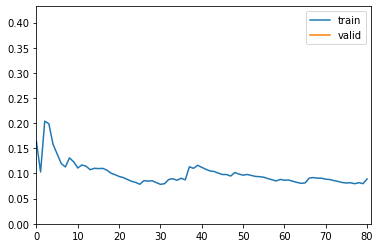

Epoch 21


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.093009,0.378153,0.919872,0.080128,02:17


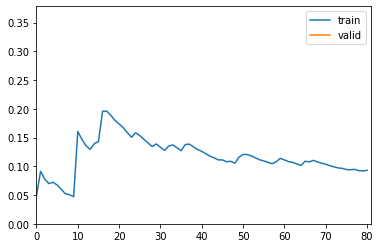

Epoch 22


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.115723,0.381336,0.923077,0.076923,02:12


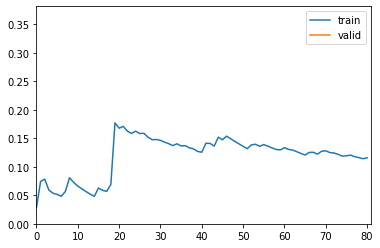

Epoch 23


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.075556,0.366871,0.923077,0.076923,02:13


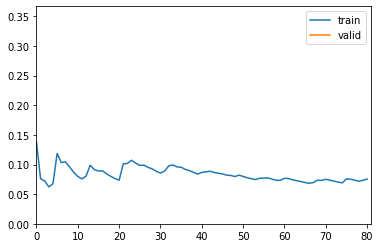

Epoch 24


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.083681,0.321170,0.919872,0.080128,02:17


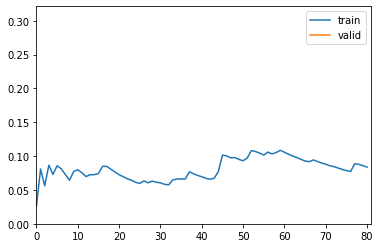

Epoch 25


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.083980,0.365323,0.921474,0.078526,02:19


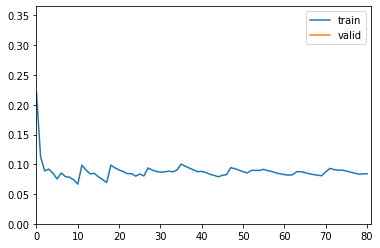

Epoch 26


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.131788,0.306445,0.942308,0.057692,02:18


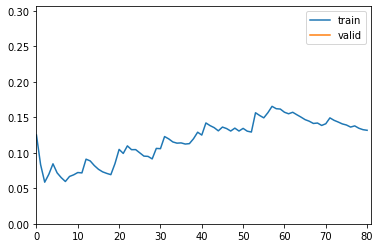

Epoch 27


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.090187,0.358255,0.923077,0.076923,02:19


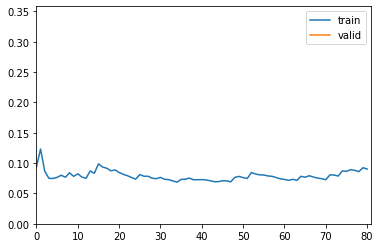

Epoch 28


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.094333,0.350617,0.915064,0.084936,02:20


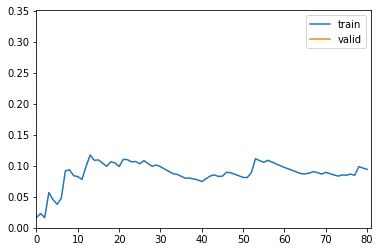

Epoch 29


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.102058,0.400202,0.924679,0.075321,02:20


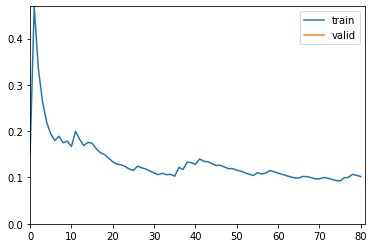

Epoch 30


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.079847,0.384503,0.926282,0.073718,02:21


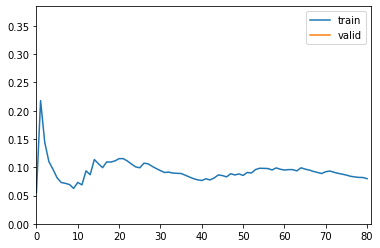

In [ ]:
learn.save("/content/chest_xray/States/stateZERO")
cycle = int(input("current cycle?")) + 1
pathtostate = "/content/chest_xray/States/state_"
for i in range(1, cycle):
  print("Epoch " + str(i))
  learn.fit_one_cycle(1)
  learn.save(pathtostate + str(i))
  


In [ ]:
!cp -r /content/chest_xray/States/ "/content/drive/My Drive/"
#saves my states in my drive

In [ ]:
cycle = 0

In [ ]:
chosenstate = int(input("which state from 1 to " + str(i) +"\n"))
learn.load(pathtostate + str(chosenstate))
#we load the epoch we decided was the best match

which state from 1 to 20
19


Learner(data=ImageDataBunch;

Train: LabelList (1311 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
NORMAL,NORMAL,NORMAL,NORMAL,NORMAL
Path: /content/chest_xray;

Valid: LabelList (624 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
NORMAL,NORMAL,NORMAL,NORMAL,NORMAL
Path: /content/chest_xray;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0

In [ ]:
#learn.save("/content/chest_xray/States/stateTemp") 
#this is the save command we learnt to save the state of our learner after training





This is the first 15 epochs i did with the Model resnet101 but we learned that at 3 and 9 epochs the AI did the best in performance so first we test it with 3 epochs as its the highest in accuracy


{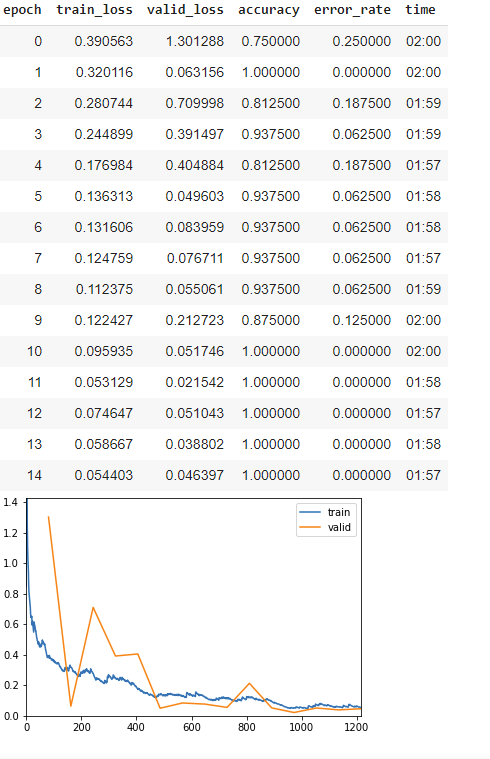
}

In [ ]:
learn.lr_find()
#this will find the learning rate of our ai so we can use the downwards trends in the graph as our points to make our ai more efficient

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


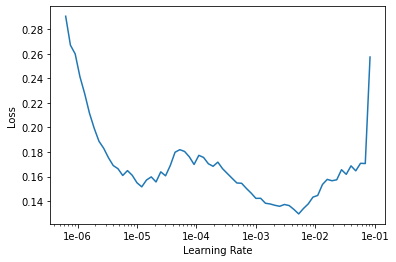

In [ ]:
learn.recorder.plot()

here we see that at 1e-05,1e-04,1e-02 we have a great dip in loss but not starting at a low loss point so we can use these learning points
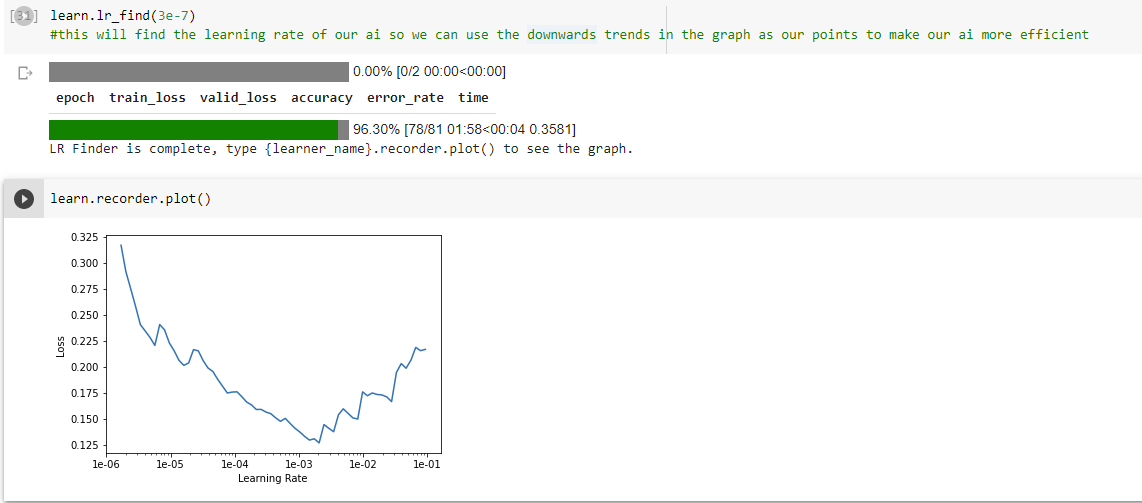

In [ ]:
pathtostate = "/content/chest_xray/States/Unfrozen_state_"

UnFrozen Epoch 1


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.082928,0.401650,0.919872,0.080128,02:21


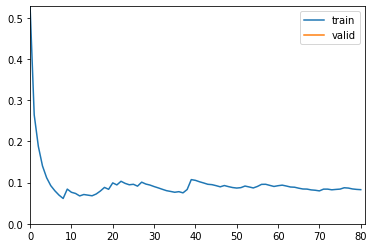

UnFrozen Epoch 2


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.080144,0.405252,0.919872,0.080128,02:21


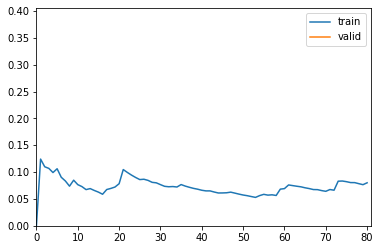

UnFrozen Epoch 3


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.090065,0.391978,0.921474,0.078526,02:21


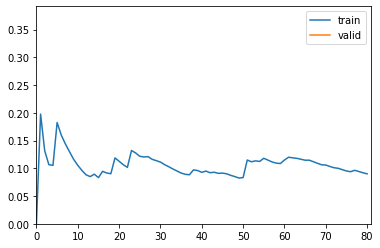

UnFrozen Epoch 4


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.103764,0.445203,0.915064,0.084936,02:23


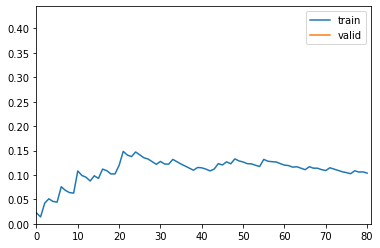

UnFrozen Epoch 5


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.081130,0.362192,0.929487,0.070513,02:24


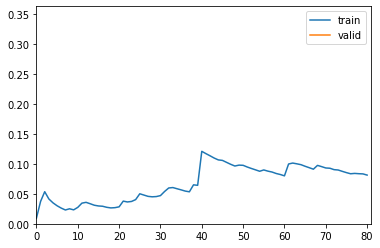

UnFrozen Epoch 6


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.083755,0.349846,0.931090,0.068910,02:22


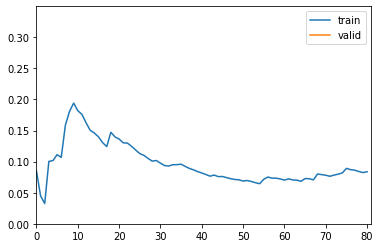

UnFrozen Epoch 7


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.084197,0.385937,0.921474,0.078526,02:24


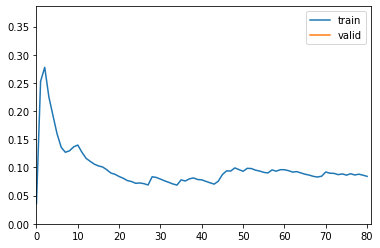

UnFrozen Epoch 8


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.138944,0.378909,0.926282,0.073718,02:24


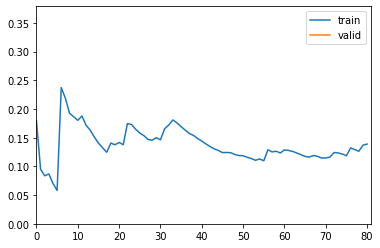

UnFrozen Epoch 9


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.139527,0.352272,0.929487,0.070513,02:25


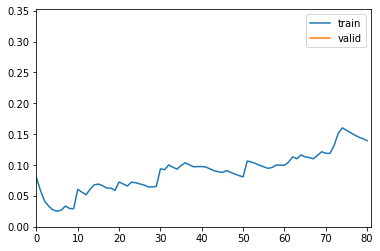

UnFrozen Epoch 10


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.095457,0.367072,0.931090,0.068910,02:23


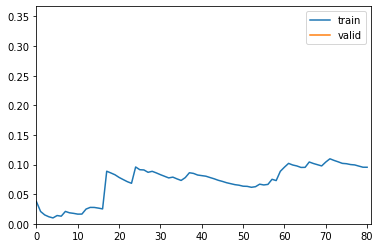

UnFrozen Epoch 11


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.078057,0.350291,0.924679,0.075321,02:21


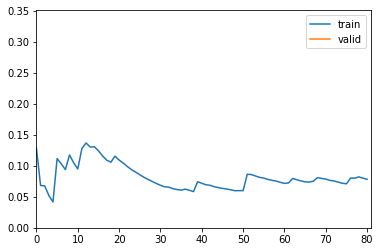

UnFrozen Epoch 12


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.084299,0.411388,0.919872,0.080128,02:16


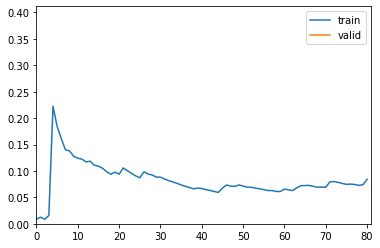

UnFrozen Epoch 13


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.086011,0.371362,0.918269,0.081731,02:16


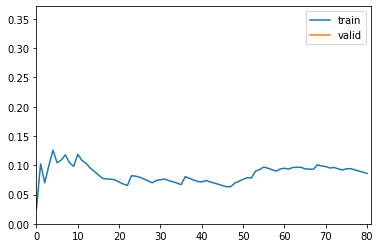

UnFrozen Epoch 14


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.060842,0.390987,0.919872,0.080128,02:18


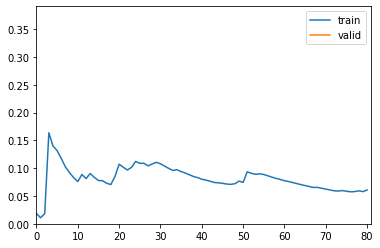

UnFrozen Epoch 15


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.071064,0.349966,0.926282,0.073718,02:19


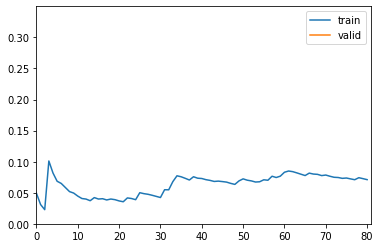

UnFrozen Epoch 16


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.060170,0.366498,0.926282,0.073718,02:16


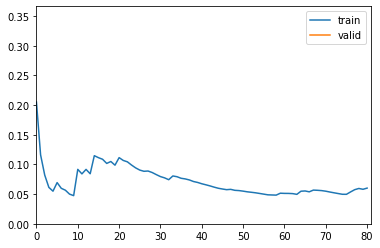

UnFrozen Epoch 17


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.084207,0.378369,0.924679,0.075321,02:17


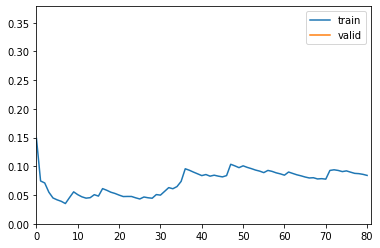

UnFrozen Epoch 18


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.067676,0.356289,0.931090,0.068910,02:19


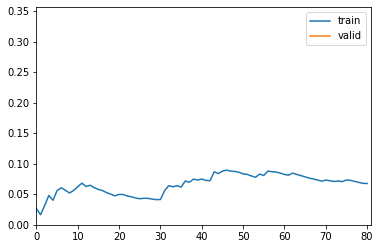

UnFrozen Epoch 19


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.073468,0.329477,0.935897,0.064103,02:18


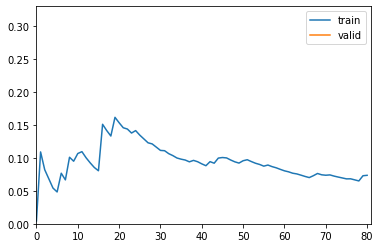

UnFrozen Epoch 20


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.061662,0.376790,0.926282,0.073718,02:21


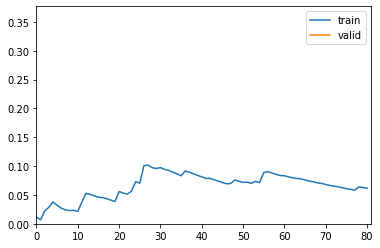

UnFrozen Epoch 21


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.060781,0.386503,0.929487,0.070513,02:23


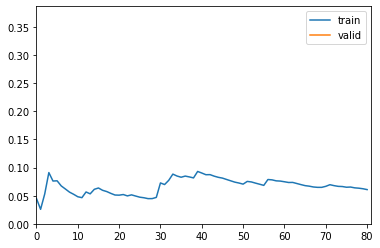

UnFrozen Epoch 22


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.063814,0.357986,0.929487,0.070513,02:26


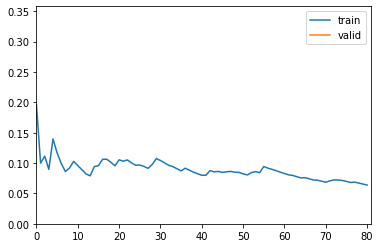

UnFrozen Epoch 23


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.098476,0.368539,0.926282,0.073718,02:26


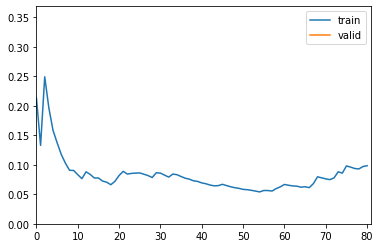

UnFrozen Epoch 24


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.070798,0.365324,0.926282,0.073718,02:24


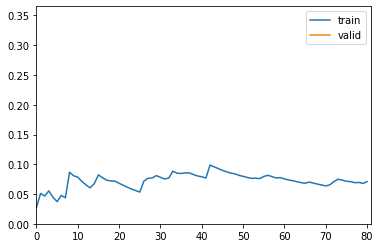

UnFrozen Epoch 25


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.090984,0.390700,0.921474,0.078526,02:23


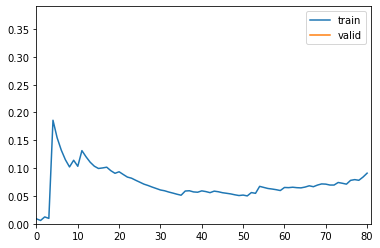

UnFrozen Epoch 26


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.099863,0.389403,0.923077,0.076923,02:21


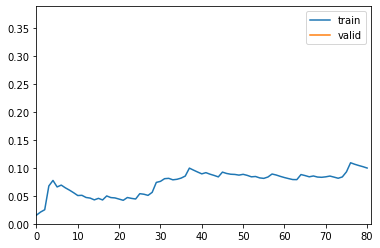

UnFrozen Epoch 27


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.060640,0.382134,0.923077,0.076923,02:23


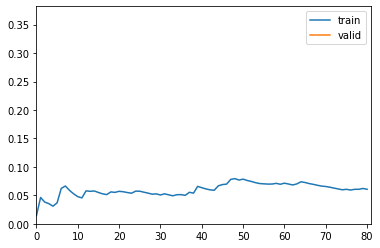

UnFrozen Epoch 28


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.116256,0.353470,0.932692,0.067308,02:23


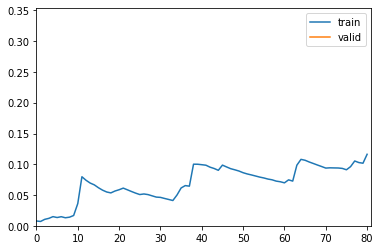

UnFrozen Epoch 29


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.075774,0.352233,0.931090,0.068910,02:21


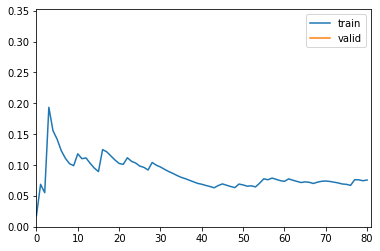

UnFrozen Epoch 30


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.065078,0.341884,0.934295,0.065705,02:21


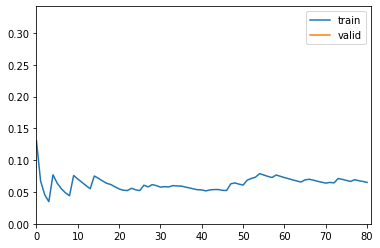

In [ ]:
learn.unfreeze()
#we unfreeze our weights so we can change them
#cycle = int(input("current cycle? ")) + 1
cycle = 31
pathtostate = "/content/chest_xray/States/Unfrozen_state_"
for i in range(1, cycle):
  print("UnFrozen Epoch " + str(i))
  learn.fit_one_cycle(1, max_lr=slice(1e-5))
  learn.save(pathtostate + str(i))
#this allows us to add a maximum learning rate at set points and save the epochs to find the best epoch for our learner


In [ ]:
!rm -fr /content/chest_xray/States/
!mkdir /content/chest_xray/States


In [ ]:
chosenstate = int(input("which state from 1 to " + str(i) +"\n"))
learn.load(pathtostate + str(chosenstate))
#we load the epoch we decided was the best match

which state from 1 to 10
2


Learner(data=ImageDataBunch;

Train: LabelList (1311 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
NORMAL,NORMAL,NORMAL,NORMAL,NORMAL
Path: /content/chest_xray;

Valid: LabelList (624 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
NORMAL,NORMAL,NORMAL,NORMAL,NORMAL
Path: /content/chest_xray;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0

In [ ]:
learn.freeze()

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


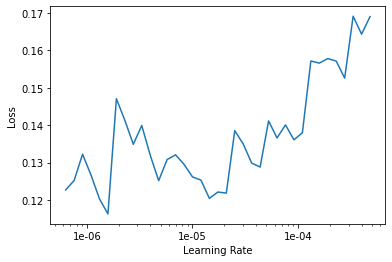

In [ ]:
learn.recorder.plot()

current cycle? 20
UnFrozen Epoch 11


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.090073,0.261946,0.924679,0.075321,02:23


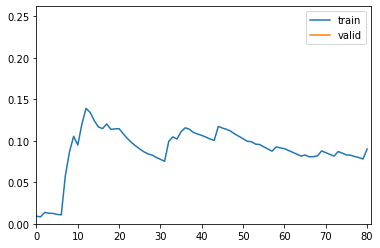

UnFrozen Epoch 12


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.081415,0.238483,0.929487,0.070513,02:21


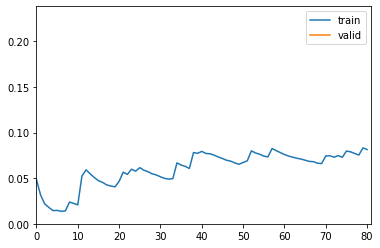

UnFrozen Epoch 13


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.087050,0.253570,0.927885,0.072115,02:21


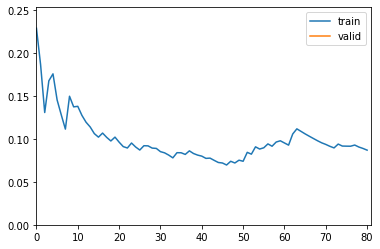

UnFrozen Epoch 14


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.067319,0.252962,0.921474,0.078526,02:22


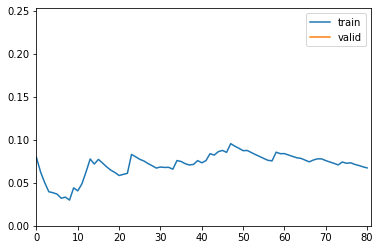

UnFrozen Epoch 15


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.086867,0.263353,0.916667,0.083333,02:22


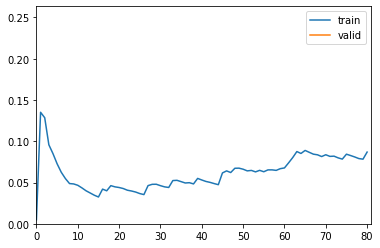

UnFrozen Epoch 16


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.053150,0.242685,0.929487,0.070513,02:22


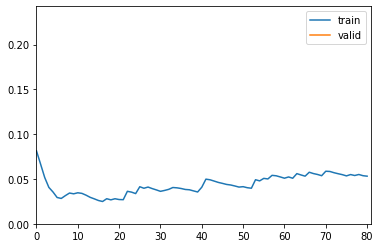

UnFrozen Epoch 17


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.074546,0.258931,0.921474,0.078526,02:21


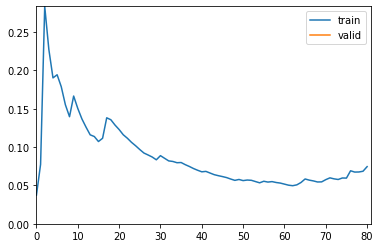

UnFrozen Epoch 18


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.099540,0.284509,0.918269,0.081731,02:21


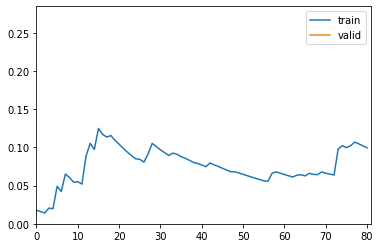

UnFrozen Epoch 19


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.065071,0.268474,0.923077,0.076923,02:22


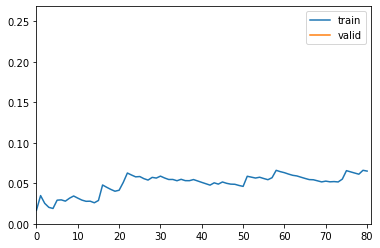

UnFrozen Epoch 20


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.060214,0.290950,0.916667,0.083333,02:21


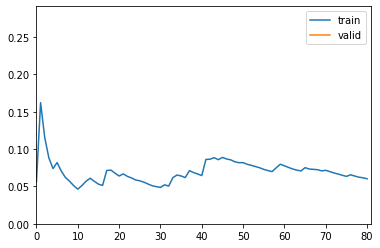

UnFrozen Epoch 21


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.058121,0.263141,0.924679,0.075321,02:22


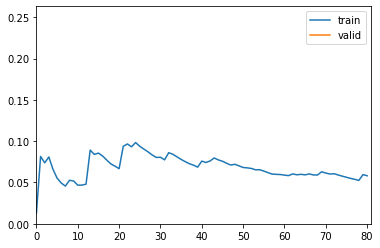

UnFrozen Epoch 22


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.059133,0.280941,0.918269,0.081731,02:21


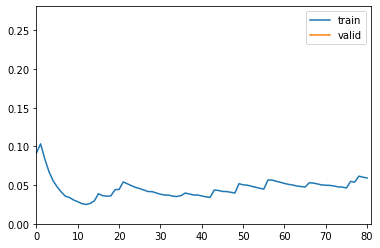

UnFrozen Epoch 23


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.073548,0.263064,0.916667,0.083333,02:22


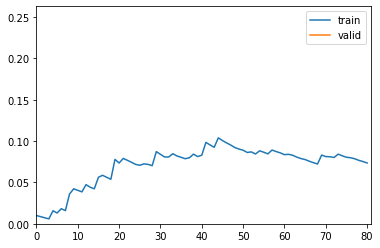

UnFrozen Epoch 24


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.076128,0.286747,0.919872,0.080128,02:22


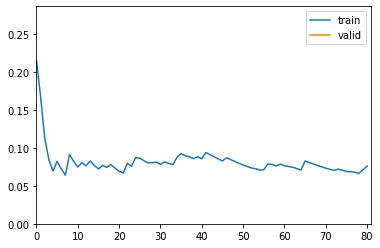

UnFrozen Epoch 25


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.072300,0.250809,0.927885,0.072115,02:21


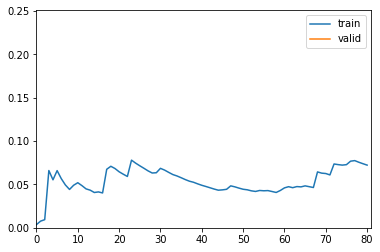

UnFrozen Epoch 26


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.063413,0.234128,0.932692,0.067308,02:22


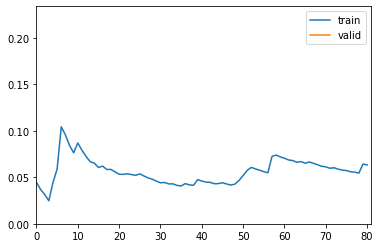

UnFrozen Epoch 27


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.058294,0.303067,0.923077,0.076923,02:22


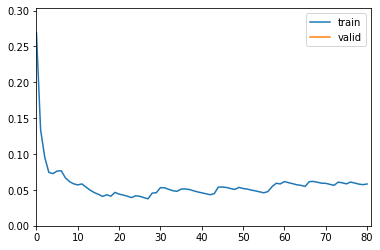

UnFrozen Epoch 28


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.062931,0.281587,0.923077,0.076923,02:24


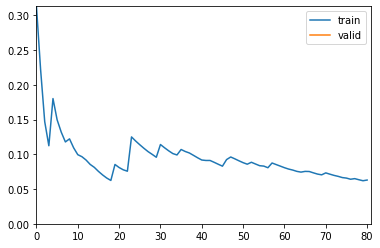

UnFrozen Epoch 29


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.069176,0.281067,0.919872,0.080128,02:22


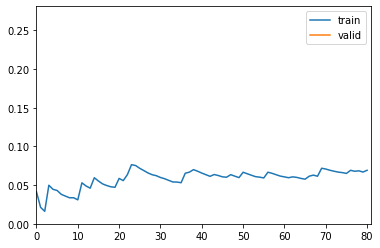

UnFrozen Epoch 30


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.049129,0.251946,0.929487,0.070513,02:23


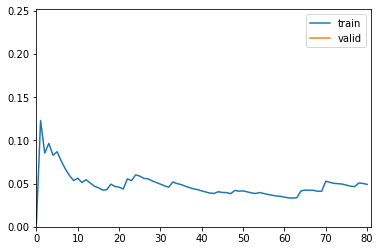

In [ ]:
cycle2 = int(input("current cycle? ")) + cycle
for i in range(cycle, cycle2):
  print("UnFrozen Epoch " + str(i))
  learn.fit_one_cycle(1, max_lr=slice(1e-6,1e-5,1e-4))
  learn.save(pathtostate + str(i))

i tried with a max_lr slice of EXAMPLE and got this as the result:



which wasnt favourable as it was overfitted so im going to try again with different slices


In [ ]:
#below are the attempts at using a test set with my AI
learn.show_results(ds_type=DatasetType.Valid)
#this shows us the results of a set bunch that we trained the ai on

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)
interp.plot_top_losses(9, figsize=(15,15))


In [ ]:
learn.export("/content/chest_xray/States/export.pkl")

In [ ]:
learn = load_learner("/content/chest_xray/States/",test = ImageList.from_folder("/content/chest_xray/test"))
preds,y = learn.get_preds(ds_type=DatasetType.Test)
preds[:5]

tensor([[4.0030e-02, 9.5997e-01],
        [9.9992e-01, 7.7774e-05],
        [9.9939e-01, 6.0821e-04],
        [9.9994e-01, 5.5527e-05],
        [9.9955e-01, 4.4935e-04]])

In [ ]:
test=ImageList.from_folder("/content/chest_xray/test")
data.add_test(test)

In [ ]:
img = data.train_ds[1][0]
learn.predict(img)

(Category tensor(0), tensor(0), tensor([9.9999e-01, 1.4437e-05]))

In [ ]:
#learn.save('State1', with_opt=True)